In [4]:
CONFIG = '../../logs/sampling_strategy/run_12/config.json'
MODEL_PATH = "../../logs/sampling_strategy/run_12/best.pth"

In [5]:
import json
import random

from IPython.display import Audio, display
import matplotlib.pyplot as plt
import sys
import os

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

with open(CONFIG) as f:
    cfg = json.load(f)

class Config:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            if isinstance(v, dict):
                setattr(self, k, Config(v))
            else:
                setattr(self, k, v)

cfg = Config(cfg)
cfg.data.root = os.path.join('..', '..', 'data')
print(cfg.training.sampling_strategy)
cfg.data.unknown_commands_included = True
cfg.data.silence_included = True
cfg.data.unknown_binary_classification = False

None


In [6]:
from dataset.dataset import SpeechCommandsDataset, get_loader

train_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='training'
)

test_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='testing'
)

num_classes:  12
Class balance in training data:
  down: 2359
  go: 2372
  left: 2353
  no: 2375
  off: 2357
  on: 2367
  right: 2367
  stop: 2380
  up: 2375
  yes: 2377
  _silence_: 320
  _unknown_: 41039
  unknown percentage: 63.10%
num_classes:  12
Class balance in testing data:
  down: 253
  go: 251
  left: 267
  no: 252
  off: 262
  on: 246
  right: 259
  stop: 249
  up: 272
  yes: 256
  _silence_: 39
  _unknown_: 4268
  unknown percentage: 62.09%


In [7]:
import torch
from modeling.model import build_model

model = build_model(cfg, test_dataset.num_classes)

state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

model.eval()

print("Model loaded successfully!")

C:\Users\jdudz\PycharmProjects\DeepLearningSpeechRecognition\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


In [8]:
def evaluate_and_display_wrong_predictions(model, test_dataset, n=5):
    model.eval() 
    
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    wrong_predictions = []
    
    for idx in indices:
        data, true_label = test_dataset[idx]
        
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            output = model(data_tensor)
            predicted_label = torch.argmax(output, dim=1).item()
        
        if predicted_label != true_label:
            wrong_predictions.append((idx, true_label, predicted_label))
        
        if len(wrong_predictions) >= n:
            break
    
    for idx, true_label, predicted_label in wrong_predictions:
        print(f"Sample Index: {idx}")
        print(f"True Label: {list(test_dataset.label_mapping.keys())[true_label]}, Predicted Label: {list(test_dataset.label_mapping.keys())[predicted_label]}")
        
        waveform, _ = test_dataset[idx]
        display(Audio(waveform, rate=cfg.data.sample_rate))
        print("-" * 50)

In [9]:
evaluate_and_display_wrong_predictions(model, test_dataset, n=10)

Sample Index: 5185
True Label: _unknown_, Predicted Label: right


--------------------------------------------------
Sample Index: 3913
True Label: _unknown_, Predicted Label: on


--------------------------------------------------
Sample Index: 2421
True Label: left, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 4956
True Label: stop, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 759
True Label: down, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 6420
True Label: yes, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 6794
True Label: _unknown_, Predicted Label: no


--------------------------------------------------
Sample Index: 6157
True Label: up, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 3172
True Label: no, Predicted Label: _unknown_


--------------------------------------------------
Sample Index: 4033
True Label: right, Predicted Label: _unknown_


--------------------------------------------------


<Figure size 1000x1000 with 0 Axes>

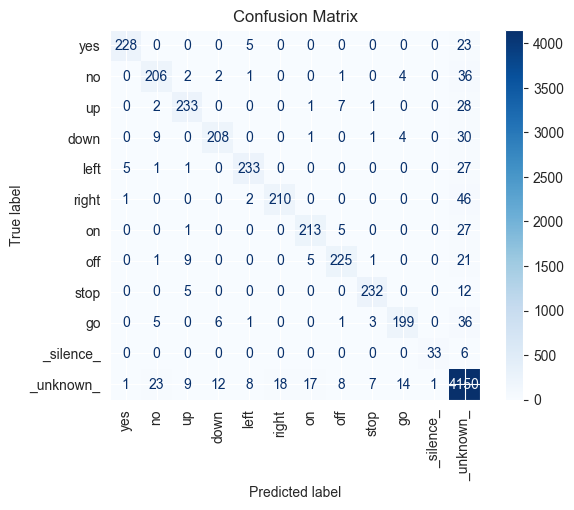

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_and_plot_confusion_matrix(model, test_dataset):
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    for idx in range(len(test_dataset)):
        data, true_label = test_dataset[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            output = model(data_tensor)
            predicted_label = torch.argmax(output, dim=1).item()
        
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_dataset.label_mapping.keys()))
    
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_and_plot_confusion_matrix(model, test_dataset)

In [11]:
import torch.nn.functional as F

model.eval()
data, true_label = test_dataset[10]
print("True label:", true_label)
# During evaluation, after getting model outputs
outputs = model(torch.tensor(data, dtype=torch.float32).unsqueeze(0))  # Shape: [B, num_classes]

# Print raw logits
print("Logits:", outputs[0].detach().cpu().numpy())

# Convert to probabilities
probs = F.softmax(outputs, dim=1)

# Print softmax probabilities for the first sample in the batch
print("Probabilities:", probs[0].detach().cpu().numpy())

True label: 11


RuntimeError: Numpy is not available

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

def train_on_small_subset(model, dataset, cfg, num_samples=10, num_epochs=20):
    # Create a small subset of the dataset
    subset_indices = list(range(num_samples))
    small_subset = Subset(dataset, subset_indices)
    dataloader = DataLoader(small_subset, batch_size=cfg.training.batch_size, shuffle=True)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.training.lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Move model to device
    model.to(device)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            
            # Forward pass
            output = model(data)
            loss = loss_fn(output, label)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")
    
    print("Training on small subset complete.")

In [ ]:
model = build_model(cfg)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
train_on_small_subset(model, train_dataset, cfg, num_samples=10000, num_epochs=10)

In [ ]:
import torch.nn.functional as F

model.eval()
data, true_label = test_dataset[10]
print("True label:", true_label)
outputs = model(torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device))  # Shape: [B, num_classes]

print("Logits:", outputs[0].detach().cpu().numpy())

probs = F.softmax(outputs, dim=1)

print("Probabilities:", f"{probs[0].detach().cpu().numpy().round(2)}")

In [ ]:
model.to('cpu')
evaluate_and_plot_confusion_matrix(model, test_dataset)